In [2]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving data-house-pricing-train.csv to data-house-pricing-train.csv


In [0]:
# %matplotlib inline
import numpy
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow.keras          import layers
from   sklearn.preprocessing     import LabelEncoder, OneHotEncoder, StandardScaler
from   sklearn.model_selection   import train_test_split
from   sklearn.feature_selection import SelectKBest
from   sklearn.feature_selection import chi2
from   sklearn.ensemble          import ExtraTreesClassifier
from   sklearn.model_selection   import train_test_split
from   sklearn                   import linear_model
from   sklearn.linear_model      import LinearRegression
from   sklearn                   import metrics
from   sklearn.model_selection   import cross_val_score
from   sklearn.model_selection   import KFold
from   sklearn.pipeline          import Pipeline
from   sklearn.preprocessing     import MinMaxScaler
from   keras.models              import Sequential
from   keras.layers              import Dense, Dropout
from   tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [3]:
print("Versions:")
print("Tensorflow:", tf.VERSION)
# 1.14.0-rc1
print("Keras: ", tf.keras.__version__)
#2.2.4-tf

Versions:
Tensorflow: 1.14.0
Keras:  2.2.4-tf


In [0]:
# Load house-pricing dataset
path = "./data-house-pricing-train.csv"
dataset = pd.read_csv(path)

In [0]:
# Function replace object typed columns with int64 typed columns by one hot encoding method
def one_hot_encoding(dataset, column_index, row_length):
  y = dataset.iloc[:, column_index].values
  le = LabelEncoder()
  y = le.fit_transform(y)
  y = pd.Series(y.reshape(row_length,))
  return y

In [0]:
# Collect categorical values to make binary variables
categorical_columns = []
for i in dataset.columns.values:
    if(dataset[i].dtype == 'object'):
        categorical_columns.append(i)

In [0]:
# Handle NaN values of dataset
def handling_NaN(dataset):
    features = dataset.columns.values
    row_length = len(dataset)
  
    for j, feature in enumerate(features):
        if (dataset[feature].dtype == 'int64' or dataset[feature].dtype == 'float64'):
            dataset[feature].fillna(dataset[feature].mean(), inplace = True)
        
    for i, feature in enumerate(features):
        if (dataset[feature].dtype == 'object'):
            dataset[feature].fillna("NA", inplace = True)
        
    return dataset

In [0]:
dataset = handling_NaN(dataset)

for k, feature in enumerate(dataset.columns.values):
    dataset[feature] = one_hot_encoding(dataset, k, len(dataset))

In [9]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,5,3,36,327,1,1,3,3,0,4,0,5,2,2,0,5,6,4,104,53,1,1,12,13,1,129,2,4,2,2,4,4,2,361,6,0,73,179,1,...,1,5,134,232,0,531,1,0,2,1,3,1,2,6,6,0,3,1,90,2,2,220,5,5,2,0,49,0,0,0,0,3,4,1,0,1,2,8,4,412
1,1,0,3,52,498,1,1,3,3,0,2,0,24,1,2,0,2,5,7,77,26,1,1,8,8,3,0,3,4,1,2,4,1,0,482,6,0,167,441,1,...,1,5,427,0,0,259,0,1,2,0,3,1,3,4,6,1,5,1,62,2,2,149,5,5,2,187,0,0,0,0,0,3,4,1,0,4,1,8,4,339
2,2,5,3,39,702,1,1,0,3,0,4,0,5,2,2,0,5,6,4,102,52,1,1,12,13,1,105,2,4,2,2,4,2,2,222,6,0,278,214,1,...,1,5,178,239,0,570,1,0,2,1,3,1,2,4,6,1,5,1,88,2,2,260,5,5,2,0,30,0,0,0,0,3,4,1,0,8,2,8,4,442
3,3,6,3,31,489,1,1,0,3,0,0,0,6,2,2,0,5,6,4,19,20,1,1,13,15,3,0,3,4,0,4,1,4,0,66,6,0,346,117,1,...,1,5,208,180,0,536,1,0,1,0,3,1,2,5,6,1,2,5,85,3,3,284,5,5,2,0,24,108,0,0,0,3,4,1,0,1,0,8,0,194
4,4,5,3,56,925,1,1,0,3,0,2,0,15,2,2,0,5,7,4,101,50,1,1,12,13,1,222,2,4,2,2,4,0,2,328,6,0,318,370,1,...,1,5,347,320,0,734,1,0,2,1,4,1,2,7,6,1,5,1,87,2,3,380,5,5,2,118,70,0,0,0,0,3,4,1,0,11,2,8,4,494


(1460, 80)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


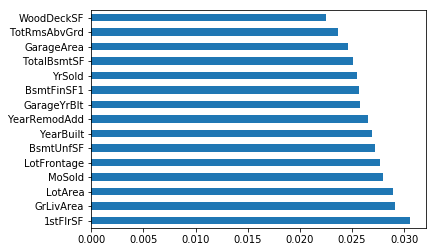

In [10]:
# Feature selection no.1 (feature importance)
del dataset['Id']
print(dataset.shape)

X = dataset.iloc[:,0:79]  #independent columns
y = dataset.iloc[:,-1]    #target column i.e price range

model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()


In [11]:
# Feature selection no.2 (univariate selection)
X = dataset.iloc[:,0:79]  #independent columns
y = dataset.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

          Specs          Score
33   BsmtFinSF1  175046.761502
43     2ndFlrSF  156662.356995
3       LotArea  153258.463160
45    GrLivArea  152684.196937
37  TotalBsmtSF  128216.765944
42     1stFlrSF  121988.499739
25   MasVnrArea  120022.908755
36    BsmtUnfSF  115155.926925
61   GarageArea   81454.454930
65   WoodDeckSF   71779.273592


In [0]:
# Generate dummy variables and remove unnecessary columns
def generate_dummies(df, dummy_column):
    dummies = pd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = pd.concat([df, dummies], axis=1)
    return df

X = pd.DataFrame.copy(dataset)

for column in categorical_columns:
    X = generate_dummies(X, column)
    
for column in categorical_columns:
    del X[column]

In [13]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_0,MSZoning_1,MSZoning_2,...,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_0,PavedDrive_1,PavedDrive_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,5,36,327,6,4,104,53,129,361,0,73,179,134,232,0,531,1,0,2,1,3,1,6,0,90,2,220,0,49,0,0,0,0,0,1,2,412,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,52,498,5,7,77,26,0,482,0,167,441,427,0,0,259,0,1,2,0,3,1,4,1,62,2,149,187,0,0,0,0,0,0,4,1,339,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,5,39,702,6,4,102,52,105,222,0,278,214,178,239,0,570,1,0,2,1,3,1,4,1,88,2,260,0,30,0,0,0,0,0,8,2,442,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,6,31,489,6,4,19,20,0,66,0,346,117,208,180,0,536,1,0,1,0,3,1,5,1,85,3,284,0,24,108,0,0,0,0,1,0,194,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,56,925,7,4,101,50,222,328,0,318,370,347,320,0,734,1,0,2,1,4,1,7,1,87,3,380,118,70,0,0,0,0,0,11,2,494,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Create a keras model and make a summary
model = Sequential()
model.add(Dense(300, input_dim=305, kernel_initializer='normal', activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               91800     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 182,401
Trainable params: 182,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [32]:
# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=300,  verbose=1, validation_split=0.2)

Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 440us/step - loss: 334.3510 - mean_squared_error: 334.3510 - mean_absolute_error: 12.2236 - val_loss: 473.8204 - val_mean_squared_error: 473.8204 - val_mean_absolute_error: 18.9838
Epoch 2/100
934/934 [==============================] - 0s 68us/step - loss: 344.8262 - mean_squared_error: 344.8262 - mean_absolute_error: 15.0441 - val_loss: 366.9923 - val_mean_squared_error: 366.9923 - val_mean_absolute_error: 17.3388
Epoch 3/100
934/934 [==============================] - 0s 67us/step - loss: 207.6413 - mean_squared_error: 207.6413 - mean_absolute_error: 11.6192 - val_loss: 216.9247 - val_mean_squared_error: 216.9247 - val_mean_absolute_error: 13.3780
Epoch 4/100
934/934 [==============================] - 0s 67us/step - loss: 164.5333 - mean_squared_error: 164.5333 - mean_absolute_error: 11.1542 - val_loss: 142.6929 - val_mean_squared_error: 142.6929 - val_mean_absolute_error: 10.2846
E

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


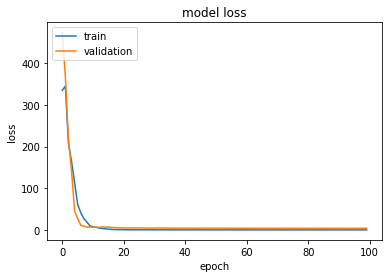

In [33]:
# Plot results
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()